 # Use Case - Tayko Software Cataloger

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer

import dmba
from dmba import (
    regressionSummary,
    adjusted_r2_score,
    AIC_score,
    BIC_score,
    classificationSummary,
    gainsChart,
    liftChart,
    stepwise_selection,
)

from fast_ml import eda

%load_ext nb_black
%matplotlib inline

no display found. Using non-interactive Agg backend


<IPython.core.display.Javascript object>

In [2]:
# Load Data
cat_df = pd.read_csv(
    "/Users/datascience/Desktop/Applied Data Science for Buisiness/Datasets/Tayko Software Cataloger.csv"
)
eda.df_info(cat_df)  # Quick Exploratory Data Analysis

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
sequence_number,int64,Numerical,2000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0,0
US,int64,Numerical,2,"[1, 0]",0,0
source_a,int64,Numerical,2,"[0, 1]",0,0
source_c,int64,Numerical,2,"[0, 1]",0,0
source_b,int64,Numerical,2,"[1, 0]",0,0
source_d,int64,Numerical,2,"[0, 1]",0,0
source_e,int64,Numerical,2,"[0, 1]",0,0
source_m,int64,Numerical,2,"[0, 1]",0,0
source_o,int64,Numerical,2,"[0, 1]",0,0
source_h,int64,Numerical,2,"[0, 1]",0,0


<IPython.core.display.Javascript object>

## 1. Each catalog costs approximately 2 dollars to mail (including printing, postage, and mailing costs). Estimate the gross profit that the firm could expect from the remaining 180,000 names if it selects them randomly from the pool.

In [3]:
# Calculate average spending from the 1,000 purchasers in the stratified sample
purchasers_df = cat_df[cat_df["Purchase"] == 1]
print(
    "Average Spending for 1000 purchasers: $",
    purchasers_df.Spending.mean(),
)

# Calculate average spending from the 2000 customers in the stratified sample
avg_spending = cat_df.Spending.mean()
# Expected average spending per customer
number_purchasers = (
    180000 * 0.107
)  # random selection probability of purchase (true response rate)
total_spending = number_purchasers * avg_spending

# Expected average profit per customer (with cost of mailing)
cost = 2 * 180000
avg_profit = total_spending - cost
print(
    "Estimate gross profit that the firm could expect from the remaining 180,000 names: $",
    avg_profit,
)

Average Spending for 1000 purchasers: $ 205.249
Estimate gross profit that the firm could expect from the remaining 180,000 names: $ 1616557.5


<IPython.core.display.Javascript object>

## 2. Develop a model for classifying a customer as a purchaser or nonpurchaser.

### 2.1 Partition the data randomly into a training set (800 records), validation set (700 records), and test set (500 records).

_Train, Validation, Test Split_

In [4]:
X = cat_df.drop(columns=["Purchase", "Spending", "sequence_number"])
y = cat_df[["Purchase", "Spending"]]
classes = ["nonpurchasers", "purchasers"]
# Split Dataset into Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    shuffle=True,
    random_state=1,
)

# Split Train into Train/Valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=700, shuffle=True, random_state=1
)


print("X_train shape: {}".format(X_train.shape))
print("X_valid shape: {}".format(X_valid.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_valid shape: {}".format(y_valid.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (800, 22)
X_valid shape: (700, 22)
X_test shape: (500, 22)
y_train shape: (800, 2)
y_valid shape: (700, 2)
y_test shape: (500, 2)


<IPython.core.display.Javascript object>

_Preprocess_

In [5]:
# list for cols to scale
cols_to_scale = ["Freq", "last_update_days_ago", "1st_update_days_ago"]

# create and fit scaler
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

# scale selected data
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

<IPython.core.display.Javascript object>

### 2.2 Run logistic regression with L2 penalty, using method LogisticRegressionCV, to select the best subset of variables, then use this model to classify the data into purchasers and nonpurchasers. Use only the training set for running the model. (Logistic regression is used because it yields an estimated “probability of purchase,” which is required later in the analysis.)

In [6]:
# Logistic Regression
logit_full = LogisticRegressionCV(penalty="l2", cv=5, max_iter=1000)
logit_full.fit(X_train, y_train["Purchase"])

# print coefficients
list_full = pd.DataFrame({"Predictor": X.columns,
                          "coefficient": logit_full.coef_[0]})
print("intercept ", logit_full.intercept_[0])
display(list_full)

# print performance measures
display(regressionSummary(y_train["Purchase"],
                          logit_full.predict(X_train)))

intercept  -0.42447313588136415


,Predictor,coefficient
0,US,0.350886
1,source_a,1.553138
2,source_c,-0.706147
3,source_b,-0.138045
4,source_d,0.885746
5,source_e,0.494972
6,source_m,0.755940
7,source_o,0.336890
8,source_h,-4.144494
9,source_r,0.369997



Regression statistics

               Mean Error (ME) : -0.0025
Root Mean Squared Error (RMSE) : 0.4000
     Mean Absolute Error (MAE) : 0.1600


None

<IPython.core.display.Javascript object>

In [7]:
# get predictions based on train_x
pred_y = logit_full.predict(X_train)

# calculate adjusted r2 and information criteria measures
print("- Metrics for using all predictors in X_train -")
print("adjusted r2 : ", adjusted_r2_score(y_train["Purchase"], pred_y, logit_full))
print("AIC : ", AIC_score(y_train["Purchase"], pred_y, logit_full))
print("BIC : ", BIC_score(y_train["Purchase"], pred_y, logit_full))

- Metrics for using all predictors in X_train -
adjusted r2 :  0.35916194784703503
AIC :  810.2364821288279
BIC :  824.2903173118317


<IPython.core.display.Javascript object>

In [8]:
# Select Subset based on Logistic Regression CV coefficients
list_full["coefficient"] = list_full["coefficient"].abs()
reduced_list = list_full[list_full["coefficient"] >= 0.4]
predictors = reduced_list["Predictor"].unique()


# Logistic Regression
logit_red = LogisticRegressionCV(penalty="l2", cv=5, max_iter=1000)
logit_red.fit(X_train[predictors], y_train["Purchase"])

# print coefficients
list_red = pd.DataFrame(
    {"Predictor": X_train[predictors].columns, "coefficient": logit_red.coef_[0]}
)
print("intercept ", logit_red.intercept_[0])
display(list_red)

# print performance measures
display(regressionSummary(y_train["Purchase"], logit_red.predict(X_train[predictors])))

logit_red_pred = logit_red.predict_proba(X_train[predictors])
red_result = pd.DataFrame(
    {
        "actual": y_train["Purchase"],
        "p(0)": [p[0] for p in logit_red_pred],
        "p(1)": [p[1] for p in logit_red_pred],
        "predicted": logit_red.predict(X_train[predictors]),
    }
)
red_result = red_result.sort_values(by=["p(1)"], ascending=False)

# confusion matrix
print("- Confustion Matrix -")
classificationSummary(red_result.actual, red_result.predicted, class_names=classes)

intercept  -0.20418475029769784


,Predictor,coefficient
0,source_a,1.388706
1,source_c,-0.636068
2,source_d,0.786423
3,source_e,0.345984
4,source_m,0.736049
5,source_h,-4.119148
6,source_t,1.056473
7,source_u,1.586167
8,source_p,1.292274
9,source_x,0.800315



Regression statistics

               Mean Error (ME) : -0.0050
Root Mean Squared Error (RMSE) : 0.4062
     Mean Absolute Error (MAE) : 0.1650


None

- Confustion Matrix -
Confusion Matrix (Accuracy 0.8350)

              Prediction
       Actual nonpurchasers    purchasers
nonpurchasers           329            68
   purchasers            64           339


<IPython.core.display.Javascript object>

In [9]:
# get predictions based on train_x
pred_y = logit_red.predict(X_train[predictors])

# calculate adjusted r2 and information criteria measures
print("- Metrics for using a reduced set of predictors -")
print("adjusted r2 : ", adjusted_r2_score(y_train["Purchase"], pred_y, logit_red))
print("AIC : ", AIC_score(y_train["Purchase"], pred_y, logit_red))
print("BIC : ", BIC_score(y_train["Purchase"], pred_y, logit_red))

- Metrics for using a reduced set of predictors -
adjusted r2 :  0.339135758717255
AIC :  834.853809062231
BIC :  848.9076442452348


<IPython.core.display.Javascript object>

In [10]:
logit_red_pred = logit_red.predict_proba(X_train[predictors])
red_result = pd.DataFrame(
    {
        "actual": y_train["Purchase"],
        "p(0)": [p[0] for p in logit_red_pred],
        "p(1)": [p[1] for p in logit_red_pred],
        "predicted": logit_red.predict(X_train[predictors]),
    }
)
red_result = red_result.sort_values(by=["p(1)"], ascending=False)

# confusion matrix
print("- Confusion Matrix for using a reduced set of predictors -")
classificationSummary(red_result.actual, red_result.predicted, class_names=classes)

- Confusion Matrix for using a reduced set of predictors -
Confusion Matrix (Accuracy 0.8350)

              Prediction
       Actual nonpurchasers    purchasers
nonpurchasers           329            68
   purchasers            64           339


<IPython.core.display.Javascript object>

## 3. Develop a model for predicting spending among the purchasers.

### 3.1  Create subsets of the training and validation sets for only purchasers’ records by filtering for Purchase = 1. 

In [11]:
# Filter dataset
purchasers_df = cat_df[cat_df["Purchase"] == 1]
X_pur = purchasers_df.drop(columns=["Purchase", "Spending", "sequence_number"])
y_pur = purchasers_df["Spending"]

# Split Dataset into Train/Valid
X_train_pur, X_valid_pur, y_train_pur, y_valid_pur = train_test_split(
    X_pur, y_pur, test_size=0.40, shuffle=True, random_state=1
)

<IPython.core.display.Javascript object>

In [12]:
# list for cols to scale
cols_to_scale = ["Freq", "last_update_days_ago", "1st_update_days_ago"]

# create and fit scaler
scaler = StandardScaler()
scaler.fit(X_train_pur[cols_to_scale])

# scale selected data
X_train_pur[cols_to_scale] = scaler.transform(X_train_pur[cols_to_scale])
X_valid_pur[cols_to_scale] = scaler.transform(X_valid_pur[cols_to_scale])

<IPython.core.display.Javascript object>

### 3.2 Develop models for predicting spending with the filtered datasets, using:

#### 3.2.1 Multiple linear regression

##### Stepwise Regression

In [13]:
# Define Model (Linear Regression)
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train_pur[variables], y_train_pur)
    return model


# Define Scoring Metric Model (AIC Score)
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(
            y_train_pur, [y_train_pur.mean()] * len(y_train_pur),
            model, df=1
        )
    return AIC_score(y_train_pur,
                     model.predict(X_train_pur[variables]), model)


# Stepwise Regression to select Best Variables
best_variables = stepwise_selection(
    X_train_pur.columns, train_model, score_model
)
print(best_variables)


Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=8123.51, constant
Step: score=7834.90, add Freq
Step: score=7814.54, add Address_is_res
Step: score=7802.53, add 1st_update_days_ago
Step: score=7799.38, add source_r
Step: score=7796.08, add source_a
Step: score=7792.91, add source_u
Step: score=7791.19, add source_h
Step: score=7791.19, unchanged None
(LinearRegression(), ['Freq', 'Address_is_res', '1st_update_days_ago', 'source_r', 'source_a', 'source_u', 'source_h'])


<IPython.core.display.Javascript object>

In [14]:
# Ridge Stepwise
def train_model(variables):
    if len(variables) == 0:
        return None
    model = Ridge()
    model.fit(X_train_pur[variables], y_train_pur)
    return model


# Define Scoring Metric Model (AIC Score)
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(
            y_train_pur, [y_train_pur.mean()] * len(y_train_pur),
            model, df=1
        )
    return AIC_score(y_train_pur,
                     model.predict(X_train_pur[variables]), model)


# Stepwise Regression to select Best Variables
best_variables = stepwise_selection(
    X_train_pur.columns, train_model, score_model
)
print(best_variables)




Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=8123.51, constant
Step: score=7834.90, add Freq
Step: score=7814.55, add Address_is_res
Step: score=7802.54, add 1st_update_days_ago
Step: score=7799.38, add source_r
Step: score=7796.09, add source_a
Step: score=7792.92, add source_u
Step: score=7791.35, add source_h
Step: score=7791.35, unchanged None
(Ridge(), ['Freq', 'Address_is_res', '1st_update_days_ago', 'source_r', 'source_a', 'source_u', 'source_h'])


<IPython.core.display.Javascript object>

In [15]:
# Lasso Stepwise
def train_model(variables):
    if len(variables) == 0:
        return None
    model = Lasso()
    model.fit(X_train_pur[variables], y_train_pur)
    return model


# Stepwise Regression to select Best Variables
best_variables = stepwise_selection(X_train_pur.columns, train_model, score_model)
print(best_variables)

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, last_update_days_ago, 1st_update_days_ago, Web order, Gender=male, Address_is_res
Start: score=8123.51, constant
Step: score=7834.92, add Freq
Step: score=7814.72, add Address_is_res
Step: score=7802.76, add 1st_update_days_ago
Step: score=7799.97, add source_r
Step: score=7796.96, add source_a
Step: score=7794.22, add source_u
Step: score=7794.22, unchanged None
(Lasso(), ['Freq', 'Address_is_res', '1st_update_days_ago', 'source_r', 'source_a', 'source_u'])


<IPython.core.display.Javascript object>

##### Multiple Linear Regression Model
_Using Best Variables from StepWise Regression_

In [16]:
# Predictors from Linear Regression stepwise regression
lm_predictors = [
    "Freq",
    "Address_is_res",
    "1st_update_days_ago",
    "source_r",
    "source_a",
    "source_u",
    "source_h",
]
# Linear Regression model
spending_lm = LinearRegression()
spending_lm.fit(X_train_pur[lm_predictors], y_train_pur)

# print coefficients
list_spending_lm = pd.DataFrame(
    {
        "Predictor": X_train_pur[lm_predictors].columns,
        "coefficient": spending_lm.coef_,
    }
)
print("intercept ", spending_lm.intercept_)
display(list_spending_lm)

# Regression Summary Report
print("\n---- Linear Regression Summary for Train Set ----")
regressionSummary(y_train_pur,
                  spending_lm.predict(X_train_pur[lm_predictors]))
print("\n---- Linear Regression Summary for Validation Set ----")
regressionSummary(y_valid_pur,
                  spending_lm.predict(X_valid_pur[lm_predictors]))

# calculate adjusted r2 and information criteria measures
pred_y = spending_lm.predict(X_valid_pur[lm_predictors])
print("- Metrics for using a Linear Regression -")
print("adjusted r2 : ", adjusted_r2_score(y_valid_pur, pred_y,
                                          spending_lm))
print("AIC : ", AIC_score(y_valid_pur, pred_y, spending_lm))
print("BIC : ", BIC_score(y_valid_pur, pred_y, spending_lm))

intercept  197.9990724045469


,Predictor,coefficient
0,Freq,142.144568
1,Address_is_res,-77.412058
2,1st_update_days_ago,-31.529344
3,source_r,71.442764
4,source_a,47.944673
5,source_u,39.982971
6,source_h,-154.856488



---- Linear Regression Summary for Train Set ----

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 157.3888
            Mean Absolute Error (MAE) : 98.7307
          Mean Percentage Error (MPE) : -99.7814
Mean Absolute Percentage Error (MAPE) : 132.0294

---- Linear Regression Summary for Validation Set ----

Regression statistics

                      Mean Error (ME) : 4.1171
       Root Mean Squared Error (RMSE) : 169.0312
            Mean Absolute Error (MAE) : 102.8035
          Mean Percentage Error (MPE) : -69.6319
Mean Absolute Percentage Error (MAPE) : 101.1441
- Metrics for using a Linear Regression -
adjusted r2 :  0.47574557702034914
AIC :  5257.217426473309
BIC :  5293.140607397281


<IPython.core.display.Javascript object>

In [17]:
# Predictors from Lasso Regression stepwise regression
lasso_predictors = [
    "Freq",
    "Address_is_res",
    "1st_update_days_ago",
    "source_r",
    "source_a",
    "source_u",
]
# Linear Regression model
spending_lm = LinearRegression()
spending_lm.fit(X_train_pur[lasso_predictors], y_train_pur)

# print coefficients
list_spending_lm = pd.DataFrame(
    {
        "Predictor": X_train_pur[lasso_predictors].columns,
        "coefficient": spending_lm.coef_,
    }
)
print("intercept ", spending_lm.intercept_)
display(list_spending_lm)

# Regression Summary Report
print("\n---- Linear (Lasso Stepwise) Regression Summary for Train Set ----")
regressionSummary(y_train_pur,
                  spending_lm.predict(X_train_pur[lasso_predictors]))
print("\n---- Linear (Lasso Stepwise) Regression Summary for Validation Set ----")
regressionSummary(y_valid_pur,
                  spending_lm.predict(X_valid_pur[lasso_predictors]))

# calculate adjusted r2 and information criteria measures
pred_y = spending_lm.predict(X_valid_pur[lasso_predictors])
print("\n- Metrics for using a Linear (Lasso Stepwise) Regression -")
print("adjusted r2 : ", adjusted_r2_score(y_valid_pur,
                                          pred_y, spending_lm))
print("AIC : ", AIC_score(y_valid_pur, pred_y, spending_lm))
print("BIC : ", BIC_score(y_valid_pur, pred_y, spending_lm))

intercept  197.23053525276893


,Predictor,coefficient
0,Freq,141.675328
1,Address_is_res,-81.853812
2,1st_update_days_ago,-31.074224
3,source_r,73.546229
4,source_a,49.446687
5,source_u,41.456702



---- Linear (Lasso Stepwise) Regression Summary for Train Set ----

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 157.8770
            Mean Absolute Error (MAE) : 99.2840
          Mean Percentage Error (MPE) : -106.0743
Mean Absolute Percentage Error (MAPE) : 136.5845

---- Linear (Lasso Stepwise) Regression Summary for Validation Set ----

Regression statistics

                      Mean Error (ME) : 2.1241
       Root Mean Squared Error (RMSE) : 167.7249
            Mean Absolute Error (MAE) : 104.1302
          Mean Percentage Error (MPE) : -83.9127
Mean Absolute Percentage Error (MAPE) : 113.0084

- Metrics for using a Linear (Lasso Stepwise) Regression -
adjusted r2 :  0.48513067699034806
AIC :  5249.010943390791
BIC :  5280.942659767655


<IPython.core.display.Javascript object>

#### 3.2.2 Regression Trees 

###### Decision Tree Regressor

In [18]:
# Decision Tree Regressor (No parameter tuning)
tree_model = DecisionTreeRegressor(random_state=1)
tree_model.fit(X_train_pur, y_train_pur)

# Regression Summary Report
print("\n---- Decision Tree Regression Summary for Train Set ----")
regressionSummary(y_train_pur, tree_model.predict(X_train_pur))
print("\n---- Decision Tree Regression Summary for Validation Set ----")
regressionSummary(y_valid_pur, tree_model.predict(X_valid_pur))


---- Decision Tree Regression Summary for Train Set ----

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 5.9231
            Mean Absolute Error (MAE) : 0.4833
          Mean Percentage Error (MPE) : -0.3462
Mean Absolute Percentage Error (MAPE) : 0.5685

---- Decision Tree Regression Summary for Validation Set ----

Regression statistics

                      Mean Error (ME) : -13.0375
       Root Mean Squared Error (RMSE) : 238.9316
            Mean Absolute Error (MAE) : 137.1975
          Mean Percentage Error (MPE) : -116.8224
Mean Absolute Percentage Error (MAPE) : 158.4389


<IPython.core.display.Javascript object>

###### Decision Tree Regressor Hyperparameter Tuning

In [19]:
# Initital Params Search
param_grid = {
    "max_features": ["None", "auto", "sqrt"],
    "max_depth": [5, 10, 15, 20, 25],
    "min_samples_leaf": [1, 3, 5],
    "min_weight_fraction_leaf": [0.0, 0.2, 0.4],
    "min_impurity_decrease": [0, 0.001, 0.005, 0.01],
    "min_samples_split": [10, 20, 30, 40, 50],
}

# Grid Search for Initital Params
gridSearch = GridSearchCV(
    DecisionTreeRegressor(random_state=1), param_grid,
    cv=5, n_jobs=-1
)
gridSearch.fit(X_train_pur, y_train_pur)
print("Initial parameters: ", gridSearch.best_params_)

Initial parameters:  {'max_depth': 10, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 50, 'min_weight_fraction_leaf': 0.0}


<IPython.core.display.Javascript object>

In [20]:
# Improving Parameters
param_grid = {
    "max_features": ["None", "auto", "sqrt"],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 2, 3],
    "min_weight_fraction_leaf": [0.0, 0.05, 0.1],
    "min_impurity_decrease": [
        0,
        0.00001,
        0.0001,
        0.0005,
        0.001,
    ],
    "min_samples_split": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 45, 50],
}
gridSearch = GridSearchCV(
    DecisionTreeRegressor(random_state=1),
    param_grid, cv=5, n_jobs=-1
)
gridSearch.fit(X_train_pur, y_train_pur)
print("Improved parameters: ", gridSearch.best_params_)


# Save best params
regTree = gridSearch.best_estimator_

# Print Regression Summary
print("\n ---- Decision Tree Regression Summary for Train Set ----")
regressionSummary(y_train_pur, regTree.predict(X_train_pur))
print("\n---- Decision Tree  Regression Summary for Validation Set ----")
regressionSummary(y_valid_pur, regTree.predict(X_valid_pur))

Improved parameters:  {'max_depth': 2, 'max_features': 'auto', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0}

 ---- Decision Tree Regression Summary for Train Set ----

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 165.6095
            Mean Absolute Error (MAE) : 99.5173
          Mean Percentage Error (MPE) : -120.2848
Mean Absolute Percentage Error (MAPE) : 144.0328

---- Decision Tree  Regression Summary for Validation Set ----

Regression statistics

                      Mean Error (ME) : 6.1654
       Root Mean Squared Error (RMSE) : 176.7016
            Mean Absolute Error (MAE) : 102.4987
          Mean Percentage Error (MPE) : -97.8716
Mean Absolute Percentage Error (MAPE) : 121.1784


<IPython.core.display.Javascript object>

###### Random Forest Regressor

In [21]:
# Initital Random Forest Model

rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train_pur, y_train_pur)

# Regression Summary Report
print("\n---- Random Forest Regression Summary for Train Set ----")
regressionSummary(y_train_pur, rf_model.predict(X_train_pur))
print("\n---- Random Forest Regression Summary for Validation Set ----")
regressionSummary(y_valid_pur, rf_model.predict(X_valid_pur))


---- Random Forest Regression Summary for Train Set ----

Regression statistics

                      Mean Error (ME) : 0.2126
       Root Mean Squared Error (RMSE) : 64.2705
            Mean Absolute Error (MAE) : 37.5195
          Mean Percentage Error (MPE) : -43.3499
Mean Absolute Percentage Error (MAPE) : 53.8972

---- Random Forest Regression Summary for Validation Set ----

Regression statistics

                      Mean Error (ME) : 0.5011
       Root Mean Squared Error (RMSE) : 166.8351
            Mean Absolute Error (MAE) : 99.6235
          Mean Percentage Error (MPE) : -96.3932
Mean Absolute Percentage Error (MAPE) : 121.6811


<IPython.core.display.Javascript object>

###### Random Forest Regressor Hyperparameter Tuning

In [22]:
rf_param_grid = {
    "max_features": ["None", "auto", "sqrt"],
    "n_estimators": [500, 1000, 1500],
    "max_depth": [5, 20, 50, 100],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": ["True", "False"],
}

randomSearch = RandomizedSearchCV(
    RandomForestRegressor(random_state=1), rf_param_grid, verbose=2, cv=3, n_jobs=-1
)
randomSearch.fit(X_train_pur, y_train_pur)
print("Initial parameters: ", randomSearch.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Initial parameters:  {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': 'False'}


<IPython.core.display.Javascript object>

In [23]:
# Improving Params
rf_param_grid = {
    "max_features": ["auto", 1, 2, 3],
    "n_estimators": [100, 1000, 2000, 3000],
    "max_depth": ["None", 25, 50, 75, 90],
    "min_samples_split": [1, 2],
    "min_samples_leaf": [1, 2],
    "bootstrap": ["True"],
}

gridSearch = GridSearchCV(
    RandomForestRegressor(random_state=1),
    rf_param_grid, verbose=2, cv=3, n_jobs=-1
)
gridSearch.fit(X_train_pur, y_train_pur)
print("Improved parameters: ", gridSearch.best_params_)


# Save best params
rf = gridSearch.best_estimator_

# Print Regression Summary
print("\n ---- Random Forest Regression Summary for Train Set ----")
regressionSummary(y_train_pur, rf.predict(X_train_pur))
print("\n---- Random Forest Regression Summary for Validation Set ----")
regressionSummary(y_valid_pur, rf.predict(X_valid_pur))

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  2.6min finished


Improved parameters:  {'bootstrap': 'True', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 3000}

 ---- Random Forest Regression Summary for Train Set ----

Regression statistics

                      Mean Error (ME) : -1.3958
       Root Mean Squared Error (RMSE) : 94.3020
            Mean Absolute Error (MAE) : 51.4337
          Mean Percentage Error (MPE) : -59.4918
Mean Absolute Percentage Error (MAPE) : 72.4183

---- Random Forest Regression Summary for Validation Set ----

Regression statistics

                      Mean Error (ME) : 0.9313
       Root Mean Squared Error (RMSE) : 165.8719
            Mean Absolute Error (MAE) : 99.6267
          Mean Percentage Error (MPE) : -97.2077
Mean Absolute Percentage Error (MAPE) : 121.3139


<IPython.core.display.Javascript object>

_Random Forest Regressor Feature Importance Plot_

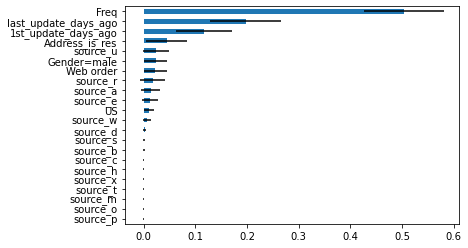

<IPython.core.display.Javascript object>

In [24]:
# variable (feature) importance plot
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame(
    {"feature": X_train_pur.columns, "importance": importances, "std": std}
)
df = df.sort_values("importance")
ax = df.plot(kind="barh", xerr="std", x="feature", legend=False)
ax.set_ylabel("")
plt.show()

A feature importance plot was made for the random forest model to gain further insight on what features were most important. The plot indicates that frequency (number of transactions in last year at source catalog) was the most critical factor in determining customer expected spending. 

#### 3.2.3  Choose one model on the basis of its performance on the validation data and explain your reasoning for selecting it 

Best Model (based on perfomance on the validation data): **Random Forest Regressor**
* Regression statistic summaries on the validation were created for each model (linear regression, decision tree regressor, and random forest regressor). Based on the regression statistics, the random forest model had the lowest mean error and root mean squared error among all models used. 

## 4. Return to the original test data partition. Note that this test data partition includes both purchasers and nonpurchasers. Create a new data frame called Score Analysis that contains the test data portion of this dataset.

In [25]:
Score_Analysis = pd.DataFrame(X_test[predictors])
Score_Analysis["Purchase"] = y_test["Purchase"]
Score_Analysis["Spending"] = y_test["Spending"]

<IPython.core.display.Javascript object>

### 4.1 Add a column to the data frame with the predicted scores from the logistic regression.

In [26]:
# Logistic Regression on Test Data Set
logit_red_pred = logit_red.predict_proba(X_test[predictors])[:, 1]
red_result = pd.DataFrame(
    {
        "actual": y_test["Purchase"],
        "predicted": logit_red.predict(X_test[predictors]),
    }
)

# confusion matrix
print("- Confustion Matrix -")
classificationSummary(red_result.actual, red_result.predicted, class_names=classes)

- Confustion Matrix -
Confusion Matrix (Accuracy 0.7940)

              Prediction
       Actual nonpurchasers    purchasers
nonpurchasers           183            47
   purchasers            56           214


<IPython.core.display.Javascript object>

In [27]:
# Insert Predicted Purchase and Predicted Probability Results from Logistic Regression
Score_Analysis["Predicted Purchase"] = logit_red.predict(X_test[predictors])
Score_Analysis["Predicted Probability"] = logit_red_pred

<IPython.core.display.Javascript object>

### 4.2 Add another column with the predicted spending amount from the prediction model chosen

In [28]:
# Random Forest Model on Test Data Set
Score_Analysis["Predicted Spending"] = rf.predict(X_test)

<IPython.core.display.Javascript object>

### 4.3 Add a column for “adjusted probability of purchase” by multiplying “predicted probability of purchase” by 0.107. This is to adjust for oversampling the purchasers (see earlier description). 

In [29]:
# Insert Adjusted Probability of Purchase
Score_Analysis["Adjusted Probability of Purchase"] = (
    Score_Analysis["Predicted Probability"] * 0.107
)

<IPython.core.display.Javascript object>

### 4.4 Add a column for expected spending: adjusted probability of purchase * predicted spending.

In [30]:
# Insert Expected Spending
Score_Analysis["Expected Spending"] = (
    Score_Analysis["Adjusted Probability of Purchase"]
    * Score_Analysis["Predicted Spending"]
)

<IPython.core.display.Javascript object>

In [31]:
Answers = Score_Analysis[
    [
        "Purchase",
        "Spending",
        "Predicted Purchase",
        "Adjusted Probability of Purchase",
        "Predicted Spending",
        "Expected Spending",
    ]
]
display(Answers)

,Purchase,Spending,Predicted Purchase,Adjusted Probability of Purchase,Predicted Spending,Expected Spending
674,0,0,0,0.002401,159.904173,0.383937
1699,1,184,1,0.101505,377.821459,38.350898
1282,0,0,1,0.060010,92.408895,5.545478
1315,1,1289,1,0.107000,1218.206196,130.348061
1210,0,0,0,0.010968,136.799538,1.500420
...,...,...,...,...,...,...
537,1,44,0,0.044393,196.773368,8.735305
1450,1,281,1,0.102533,270.075245,27.691497
1919,1,514,1,0.105451,515.357064,54.345048
255,0,0,0,0.002401,163.612844,0.392841


<IPython.core.display.Javascript object>

### 4.5 Plot the cumulative gains chart of the expected spending (cumulative expected spending as a function of number of records targeted)

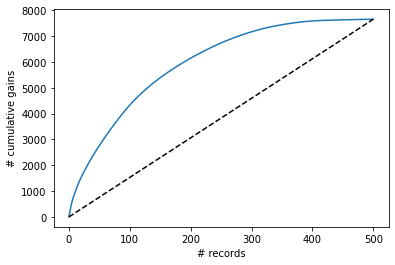

<IPython.core.display.Javascript object>

In [32]:
# Create a new dataframe for Gains
gains_df = pd.gains_df = pd.DataFrame(Score_Analysis["Expected Spending"])

# Sort values in Gains Data Frame
gains_df = gains_df.sort_values(by=["Expected Spending"], ascending=False).reset_index(
    drop=True
)

# Plot a gains chart
gainsChart(gains_df["Expected Spending"])
plt.show()

Based on the gains curve, for instance, if we select the top 20% of cases (100 records) based on the model, we will select about 60% of the target class. If we select the top 80% of cases, we would expect 100% of the target class. 

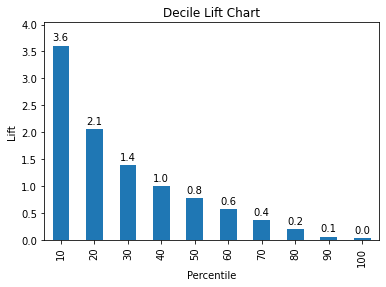

<IPython.core.display.Javascript object>

In [33]:
liftChart(gains_df["Expected Spending"], labelBars=True)
plt.show()

Selecting the top 20% of observations based on model probability, this selection contains 2.1x higher % target class cases compared to a random selection

### 4.6 Using this cumulative gains curve, estimate the gross profit that would result from mailing to the 180,000 names on the basis of your data mining models.

In [34]:
# Expected average spending per customer
avg_spending = Score_Analysis["Expected Spending"].mean()

# Number of Customers targeted among the 180,000
# Based on Gains Curve, We will target 20% of 180,0000
number_purchasers = 180000 * 0.2  

total_spending = number_purchasers * avg_spending

# Expected average profit per customer (with cost of mailing)
cost = 2 * number_purchasers
avg_profit = total_spending - cost

print("Number of customers targeted from the 180,000 mailing list: ",
      number_purchasers)
print("\nTotal cost to mail for targeted customers: $", cost)
print(
    "\nEstimate gross profit that the firm could expect from the remaining 36,0000 names: $",
    round(avg_profit, 2),
)


Number of customers targeted from the 180,000 mailing list:  36000.0

Total cost to mail for targeted customers: $ 72000.0

Estimate gross profit that the firm could expect from the remaining 36,0000 names: $ 479505.8


<IPython.core.display.Javascript object>

* If we were to target 20% of the customers in the 180,000 mailing list, the expected gross profit would be about 480,000.

In [35]:
# Expected average spending per customer
avg_spending = Score_Analysis["Expected Spending"].mean()

# Number of Customers targeted among the 180,000
number_purchasers = 180000 * 0.8
# Based on Gains CurveWe will target 80% of 180,0000
total_spending = number_purchasers * avg_spending

# Expected average profit per customer (with cost of mailing)
cost = 2 * number_purchasers
avg_profit = total_spending - cost

print("Number of customers targeted from the 180,000 mailing list: ", number_purchasers)
print("\nTotal cost to mail for targeted customers: $", cost)
print(
    "\nEstimate gross profit that the firm could expect from the remaining 144,0000 names: $",
    round(avg_profit, 2),
)

Number of customers targeted from the 180,000 mailing list:  144000.0

Total cost to mail for targeted customers: $ 288000.0

Estimate gross profit that the firm could expect from the remaining 144,0000 names: $ 1918023.2


<IPython.core.display.Javascript object>

* If we were to target 80% of the customers in the 180,000 mailing list, the expected gross profit would be about 1.92 million.


## 5. Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team.


Tayko, a software catalog firm, mails out catalogs to their mailing list in an attempt to expand its customer base. Data mining techniques were used to select the names that have the best chance of performing well instead of randomly selecting or sending all customers a catalog. To achieve this, Tayko has supplied its customer list of 200,000 names to the pool in order to implement a predictive model to choose the best candidates from the mailing list. 

20,000 of the 200,000 names were used as a sample. Among that sample, a stratified sample 1000 purchasers and 1000 non purchasers were selected to optimize the performance of the data mining techniques. Therefore, the predictive model will adjust the true probability of purchase of the 20,000 samples. Logistic regression with L2 penalty was used to predict purchasers and probability of purchasers. To reduce the predictors, near zero coefficients were removed to avoid model overfitting. In addition, multiple linear regression and regression trees were implemented to predict spending for each customer. For linear regression, stepwise regression was used to reduce the predictors for modeling. Moreover, two regression tree models were used: decision tree and random forest. The tuned random forest regressor yielded the best results among all predictive spending models.

As it stands, the gross profit of sending out catalogs is around 1.6 million if the firm randomly selected from the pool from the remaining 180,000 names. From the data mining techniques, a cumulative gains chart of the expected spending was created for the test set. Based on the gains curve, we could expect near 100 percent of the target class by selecting the top 80 percent of cases. Therefore, 144,000 names will be targeted among the 180,000 names in the pool. By doing so, the cost of mailing the catalogs is reduced from 360,000 to 288,000. Moreover, the firm can estimate a gross profit of 1.92 million using the predictive model, which is an increase of 300,000 from randomly selecting names. 